In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [15]:
path_lbl.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009180_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01110_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08115_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07200_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07020_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_05340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08087_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f05100_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f04470_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01440_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f01140_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_05190_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_04830_P.png'),
 PosixPath('/home

In [5]:
# Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01950.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_05970.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08400.png')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009180_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01110_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08115_P.png')]

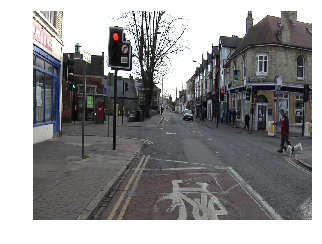

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [18]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [22]:
# get mask file
mask_f = get_y_fn(img_f); mask_f

PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01950_P.png')

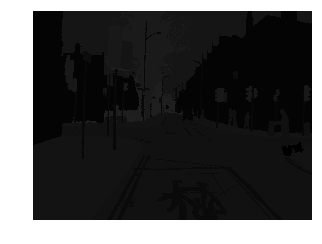

In [25]:
# try to show mask png image file using normal open_image
mask_img = open_image(mask_f)
mask_img.show(figsize=(5,5), alpha=1)
# error show black image ???

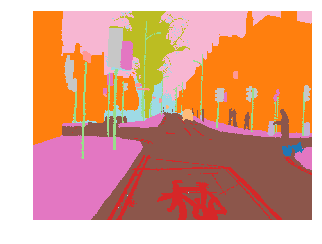

In [26]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [27]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [28]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [29]:
# Datasets

In [30]:
size = src_size//2
bs = 8

In [31]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [32]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

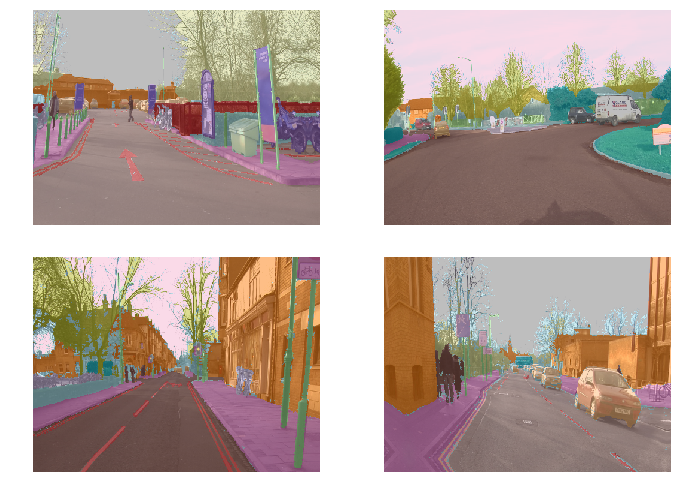

In [33]:
data.show_batch(2, figsize=(10,7))

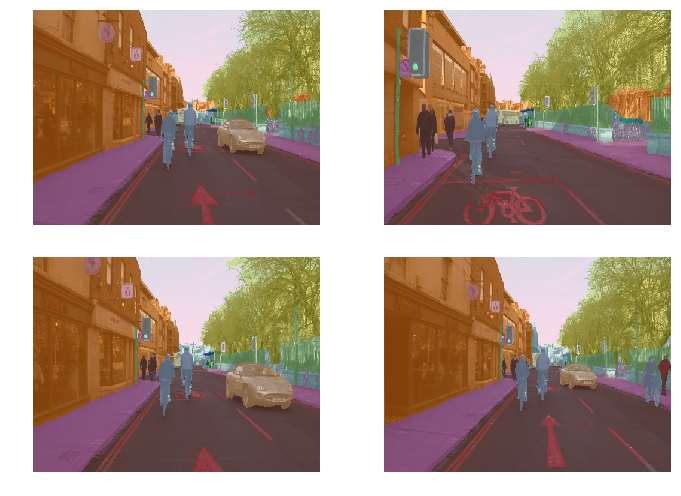

In [34]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [35]:
# MOdel

In [36]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask].float().mean())

In [37]:
metrics=acc_camvid
# metrics=accuracy

In [38]:
wd=1e-2

In [39]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [40]:
lr_find(learn)

RuntimeError: CUDA out of memory. Tried to allocate 5.12 MiB (GPU 0; 11.17 GiB total capacity; 2.08 GiB already allocated; 1.81 MiB free; 9.87 MiB cached)

In [ ]:
learn.recorder.plot()